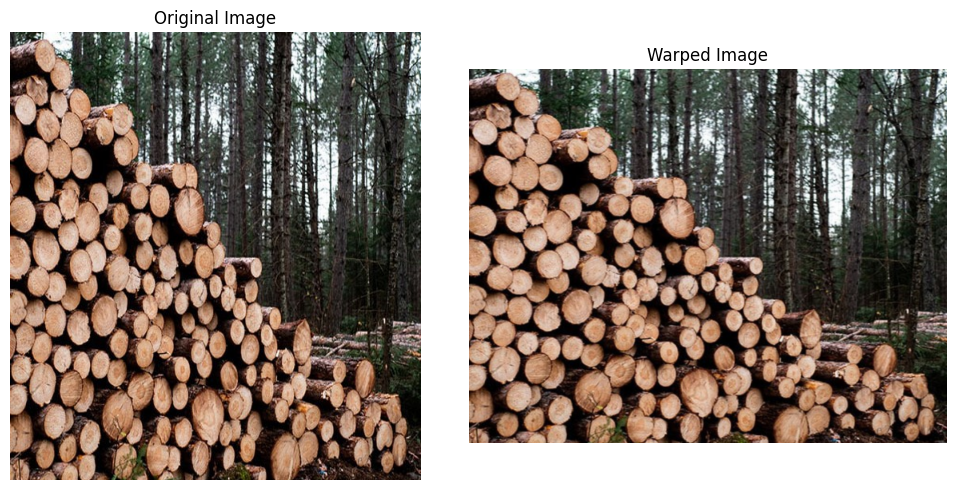

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def warp_image(image_path, pts1, width=800, height=628):
    image = cv.imread(image_path)
    pts2 = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
    matrix = cv.getPerspectiveTransform(pts1, pts2)
    warped_image = cv.warpPerspective(image, matrix, (width, height))
    return image, warped_image

image_path = '../Task_2/logs-4.jpg'
pts1 = np.float32([[2, 2], [511, 3], [509, 555], [3, 556]])

original_image, warped_image = warp_image(image_path, pts1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.axis('off')

plt.tight_layout()
plt.show()

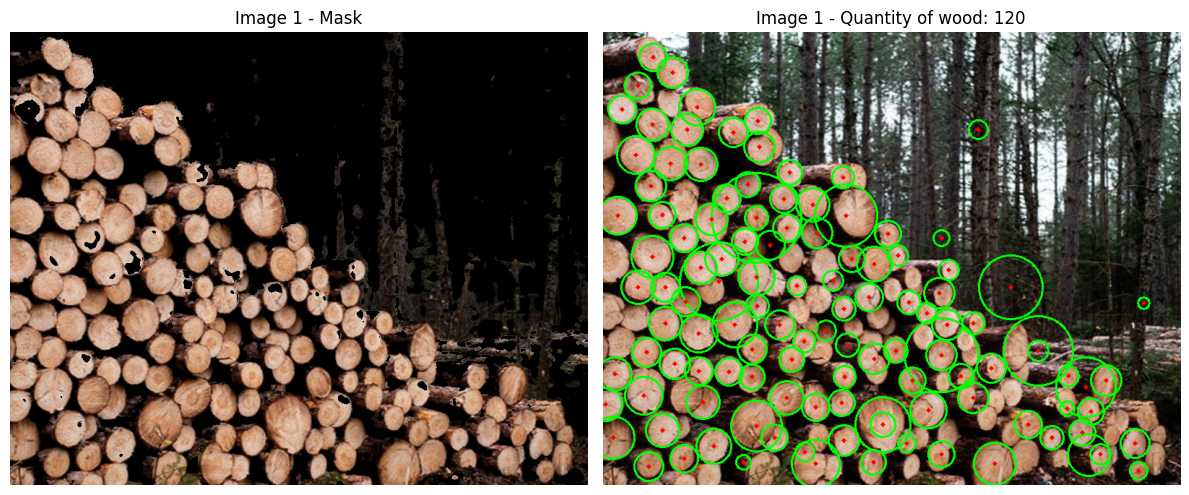

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def process_image_with_mask(image):
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    filtered_image = cv.bilateralFilter(image_rgb, 9, 75, 75)
    hsv = cv.cvtColor(filtered_image, cv.COLOR_RGB2HSV)
    lower_brown = np.array([5, 50, 20])
    upper_brown = np.array([30, 255, 255])
    mask = cv.inRange(hsv, lower_brown, upper_brown)
    masked_image = cv.bitwise_and(image_rgb, image_rgb, mask=mask)
    gray = cv.cvtColor(masked_image, cv.COLOR_RGB2GRAY)
    gray_blurred = cv.GaussianBlur(gray, (5, 5), 0)
    circles = cv.HoughCircles(
        gray_blurred,
        cv.HOUGH_GRADIENT_ALT,
        dp=1.5,
        minDist=15,
        param1=300,
        param2=0.5,
        minRadius=3,
        maxRadius=70
    )
    output_image = image_rgb.copy()
    pipes_count = 0
    if circles is not None:
        circles = np.uint16(np.around(circles[0, :]))
        filtered_circles = remove_overlapping_circles(circles, min_dist=30, image_shape=output_image.shape[:2])
        for (a, b, r) in filtered_circles:
            cv.circle(output_image, (a, b), r, (0, 255, 0), 2)
            cv.circle(output_image, (a, b), 1, (255, 0, 0), 3)
            pipes_count += 1
    return masked_image, output_image, pipes_count

def remove_overlapping_circles(circles, min_dist, image_shape):
    height, width = image_shape[:2]
    filtered_circles = []
    for x1, y1, r1 in circles:
        x1, y1 = np.clip(x1, 0, width - 1), np.clip(y1, 0, height - 1)
        overlapping = False
        for x2, y2, r2 in filtered_circles:
            distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            if distance < min_dist and abs(float(r1) - float(r2)) < 15:
                overlapping = True
                if r1 > r2:
                    filtered_circles.remove((x2, y2, r2))
                    filtered_circles.append((x1, y1, r1))
                break
        if not overlapping:
            filtered_circles.append((x1, y1, r1))
    return filtered_circles

masked_image, processed_image, count = process_image_with_mask(warped_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.title(f"Image 1 - Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title(f"Image 1 - Quantity of wood: {count}")
plt.axis('off')

plt.tight_layout()
plt.show()